In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os

import warnings
warnings.filterwarnings('ignore')

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

import arviz as az
import jax.numpy as jnp
import jax.random as random
from numpyro.infer import MCMC, NUTS, Predictive
import graphviz

# SGT model
https://num.pyro.ai/en/stable/tutorials/time_series_forecasting.html 

In [2]:
def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150

    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])



In [3]:
today = '2022-11-19'
forecast = 2 * 365 # days ahead

# Deals

In [4]:
df_deals_orig = pd.read_csv('offline_info/Daily_Active_Deal_TiB_Change_Breakdown.csv')
df_deals = df_deals_orig.copy()
df_deals

,stateTime,New Active Deal,Expired Deals,Terminated Deals
0,2022-05-26,392.80,-0.49,-0.53
1,2022-05-27,428.46,-0.99,-0.23
2,2022-05-28,308.41,-3.81,-0.35
3,2022-05-29,213.64,-1.62,-0.14
4,2022-05-30,292.30,-2.40,-0.06
...,...,...,...,...
174,2022-11-16,1901.76,-17.53,-3.86
175,2022-11-17,1824.91,-22.91,-4.19
176,2022-11-18,2575.35,-20.59,-2.42
177,2022-11-19,1791.93,-23.61,-1.89


Text(0.5, 1.0, 'Deals onboard (PiB)')

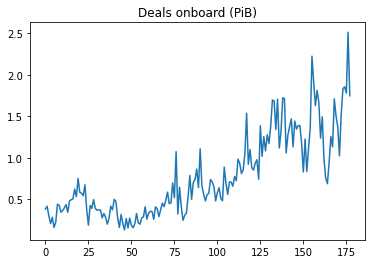

In [5]:
df_deals['deals_onboard'] = df_deals['New Active Deal'] / 1024
df_deals = df_deals[df_deals.stateTime <= today]
df_deals.deals_onboard.plot(); plt.title('Deals onboard (PiB)')

In [6]:
x_train = df_deals.index.values
y_train = jnp.array(df_deals.deals_onboard.values)

print(jnp.argsort(autocorrelation(y_train))[::-1])

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_marginal = predictive(random.PRNGKey(1), y_train, seasonality=1000, future=forecast)[
    "y_forecast"
]

[  0   1   2   3   4  18  16   6   8  17  14   7   5  20  15  13  19  10
  12  21   9  11  22  23  26  28  24  29  25  27  30  31  34  32  33  35
  38  37  41  36  39  42  43  40  44  45  46  47  48  49  51  50  52  53
  55  57  54  56  59  58  60  61  62  63  64  65  67  66  68  69  70  71
  72  73  75  74  77  78  79  76  80  81  82  83  85  84  86  87  88  89
  90  91  92  98  93  94  97  99 100  96  95 101 102 103 104 105 106 157
 158 107 159 108 160 109 115 116 110 111 136 156 112 147 114 117 118 138
 137 113 154 149 148 139 135 146 119 161 153 140 150 145 155 120 144 141
 142 134 151 162 121 143 152 133 132 128 122 123 127 124 126 125 129 131
 130 163 164 165 166 167 177 168 169 170 175 171 176 172 174 173]


sample: 100%|█████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.55it/s, 127 steps of size 5.15e-02. acc. prob=0.82]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.01      0.01      0.01     -0.00      0.02   3081.36      1.00
       init_s[0]      0.04      1.11      0.00     -0.68      0.72    973.22      1.00
       init_s[1]      0.11      0.12      0.10     -0.08      0.31   6875.11      1.00
       init_s[2]     -0.02      0.10     -0.01     -0.18      0.16   7256.15      1.00
       init_s[3]     -0.09      0.13     -0.06     -0.31      0.10   4281.36      1.00
       init_s[4]      0.02      0.12      0.01     -0.18      0.21   5950.02      1.00
       init_s[5]     -0.16      0.19     -0.11     -0.48      0.07   2936.55      1.00
       init_s[6]     -0.08      0.14     -0.05     -0.33      0.11   3855.34      1.00
       init_s[7]      0.26      0.25      0.22     -0.11      0.65   5265.95      1.00
       init_s[8]      0.14      0.16      0.12     -0.09      0.40   6152.31      1.00
       init_s[9]     -0.03      0.11     -

(0.0, 40.0)

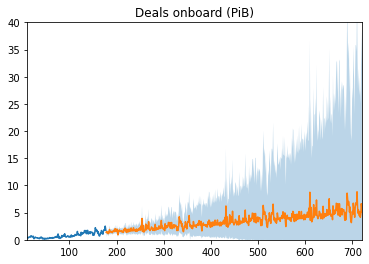

In [7]:
deal_onboard_dist = forecast_marginal.copy()

y_pred = jnp.median(forecast_marginal, axis=0)
hpd_low, hpd_high = hpdi(forecast_marginal)
x_pred = np.arange(len(y_train), len(y_pred) + len(y_train))
df_deals.deals_onboard.plot(); plt.title('Deals onboard (PiB)')
plt.plot(x_pred, y_pred)
plt.fill_between(x_pred, hpd_low, hpd_high, alpha=0.3)
plt.xlim(10,720)
plt.ylim(0,40)

# Raw byte onboarding

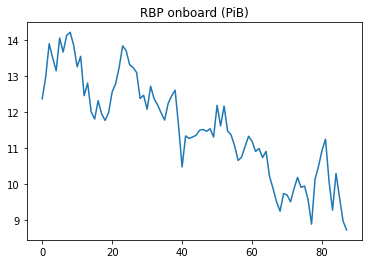

In [8]:
df_onboarding_orig = pd.read_csv('offline_info/Sector_Onboarding_Breakdown_by_Sector_Size.csv')
df_onboarding = df_onboarding_orig.copy()
df_onboarding = df_onboarding[df_onboarding.stateTime <= today]
df_onboarding.Total.plot(); plt.title('RBP onboard (PiB)');

In [9]:
x_train = df_onboarding.index.values
y_train = jnp.array(df_onboarding['Total'].values)

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_marginal = predictive(random.PRNGKey(1), y_train, seasonality=1000, future=forecast)[
    "y_forecast"
]

sample: 100%|██████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.27it/s, 15 steps of size 5.26e-02. acc. prob=0.85]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.09      0.09     -0.06     -0.22      0.01    869.63      1.00
       init_s[0]     -1.18     40.90     -0.07    -20.85     23.53    378.86      1.00
       init_s[1]      0.63      0.32      0.64      0.17      1.13   3116.13      1.00
       init_s[2]      1.54      0.36      1.57      0.98      2.06   1891.23      1.00
       init_s[3]      1.17      0.35      1.20      0.60      1.69   1694.01      1.00
       init_s[4]      0.83      0.37      0.86      0.18      1.33   1455.06      1.00
       init_s[5]      1.72      0.38      1.77      1.08      2.26   1293.50      1.00
       init_s[6]      1.35      0.40      1.40      0.72      1.96   1238.43      1.00
       init_s[7]      1.82      0.41      1.87      1.12      2.38   1004.49      1.00
       init_s[8]      1.92      0.42      1.98      1.15      2.50   1210.79      1.00
       init_s[9]      1.58      0.42      

(0.0, 720.0)

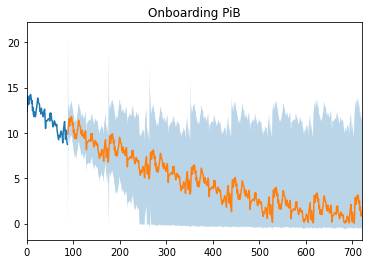

In [10]:
rawbyte_onboard_dist = forecast_marginal

y_pred = jnp.median(forecast_marginal, axis=0)
hpd_low, hpd_high = hpdi(forecast_marginal)
x_pred = np.arange(len(y_train), len(y_pred) + len(y_train))
df_onboarding.Total.plot(); plt.title('Onboarding PiB')
plt.plot(x_pred, y_pred)
plt.fill_between(x_pred, hpd_low, hpd_high, alpha=0.3)
plt.xlim(0,720)

# Extension rate = Extensions / (Expirations + Extensions)

In [12]:
df_renewal_rate_orig = pd.read_csv('offline_info/Scheduled_Expiration_by_Date_Breakdown_in_PiB.csv')
df_renewal_rate = df_renewal_rate_orig.copy()
df_renewal_rate = df_renewal_rate[df_renewal_rate.stateTime <= today]

df_renewal_rate['Renewal_Rate'] = df_renewal_rate['Extend'] / (df_renewal_rate['Extend'] 
                             + df_renewal_rate['Expired']
                             + df_renewal_rate['Potential Expire'])


### Extended

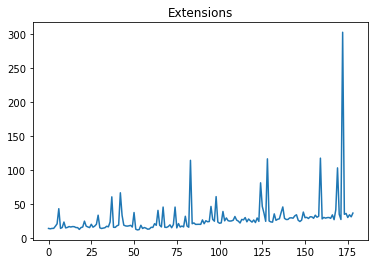

In [13]:
df_renewal_rate['Extend'].plot();plt.title("Extensions");

In [14]:
x_train = df_renewal_rate.index.values
y_train = jnp.array(df_renewal_rate['Extend'].values)

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_marginal = predictive(random.PRNGKey(1), y_train, seasonality=1000, future=forecast)[
    "y_forecast"
]

sample: 100%|█████████████████████████████████████████████████| 10000/10000 [00:52<00:00, 190.54it/s, 383 steps of size 5.37e-02. acc. prob=0.68]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.46      0.41      0.36      0.01      1.04    184.22      1.01
       init_s[0]      4.36     55.98      0.20    -26.48     23.46    275.59      1.01
       init_s[1]     -0.86      0.81     -0.85     -2.08      0.47    313.79      1.01
       init_s[2]     -0.33      0.84     -0.28     -1.75      0.98   2245.44      1.00
       init_s[3]     -0.35      0.89     -0.32     -1.74      1.06    241.54      1.01
       init_s[4]      2.59      0.99      2.62      1.10      4.18     98.72      1.02
       init_s[5]      5.71      1.16      5.85      3.35      7.20     38.78      1.05
       init_s[6]     27.83      1.12     27.81     25.98     29.54   2360.81      1.00
       init_s[7]     -0.96      1.03     -0.94     -2.56      0.66    129.95      1.02
       init_s[8]      0.35      1.00      0.41     -1.28      1.96   2447.11      1.00
       init_s[9]      8.01      1.16      

In [15]:
predictions_extend = forecast_marginal.copy()

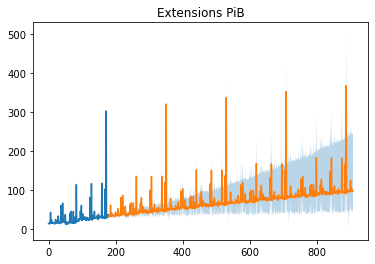

In [16]:
y_pred = jnp.median(forecast_marginal, axis=0)
hpd_low, hpd_high = hpdi(forecast_marginal)
x_pred = np.arange(len(y_train), len(y_pred) + len(y_train))
df_renewal_rate['Extend'].plot(); plt.title('Extensions PiB')
plt.plot(x_pred, y_pred)
plt.fill_between(x_pred, hpd_low, hpd_high, alpha=0.3)

### Expired

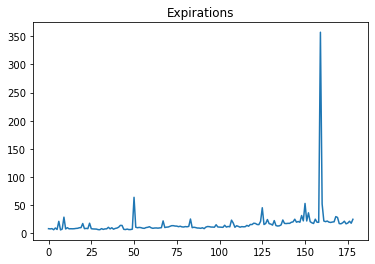

In [17]:
df_renewal_rate['Expired'].plot();plt.title("Expirations");

In [18]:
x_train = df_renewal_rate.index.values
y_train = jnp.array(df_renewal_rate['Expired'].values)

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_marginal = predictive(random.PRNGKey(1), y_train, seasonality=1000, future=forecast)[
    "y_forecast"
]

predictions_expire = forecast_marginal.copy()

sample: 100%|█████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.86it/s, 127 steps of size 5.18e-02. acc. prob=0.78]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.18      0.16      0.14     -0.00      0.42   1511.41      1.00
       init_s[0]     -6.83     80.39     -0.04    -15.35     16.63    229.49      1.01
       init_s[1]     -0.31      0.55     -0.34     -1.21      0.55   5641.05      1.00
       init_s[2]      0.22      0.59      0.19     -0.74      1.18   4959.26      1.00
       init_s[3]     -1.62      0.66     -1.67     -2.69     -0.56   4502.04      1.00
       init_s[4]      1.35      0.67      1.32      0.26      2.41   5249.48      1.00
       init_s[5]     -1.13      0.68     -1.16     -2.29     -0.05   4561.95      1.00
       init_s[6]     13.16      0.82     13.13     11.82     14.44   3803.10      1.00
       init_s[7]     -1.87      0.73     -1.89     -3.02     -0.65   3493.14      1.00
       init_s[8]     -0.49      0.71     -0.51     -1.60      0.69   4109.28      1.00
       init_s[9]     20.43      0.82     2

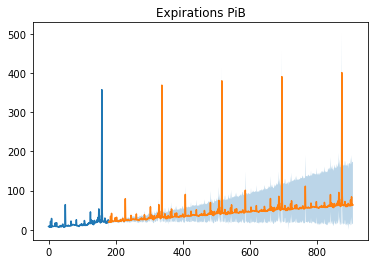

In [19]:
y_pred = jnp.median(forecast_marginal, axis=0)
hpd_low, hpd_high = hpdi(forecast_marginal)
x_pred = np.arange(len(y_train), len(y_pred) + len(y_train))
df_renewal_rate['Expired'].plot(); plt.title('Expirations PiB')
plt.plot(x_pred, y_pred)
plt.fill_between(x_pred, hpd_low, hpd_high, alpha=0.3)

In [20]:
renewal_dist = predictions_extend / (predictions_extend + predictions_expire)

In [21]:
fil_plus_rate_dist = deal_onboard_dist / rawbyte_onboard_dist 

Text(0.5, 0, 'days')

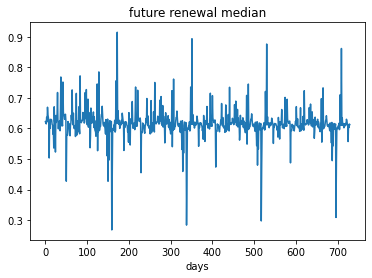

In [47]:
plt.plot(jnp.median(renewal_dist, axis=0))
plt.title('future renewal median'); plt.xlabel('days')

Text(0.5, 0, 'days')

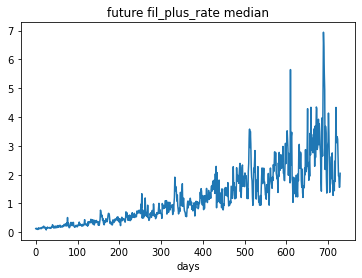

In [48]:
plt.plot(jnp.median(fil_plus_rate_dist, axis=0))
plt.title('future fil_plus_rate median'); plt.xlabel('days')

In [49]:
n_samples = 500 # subsample 500 sufficient
df_rawbyte_onboard_dist = pd.DataFrame(rawbyte_onboard_dist[:50]) #future days along columns
df_rawbyte_onboard_dist['dist'] = 'rb_onboard_power'

df_renewal_rate_dist = pd.DataFrame(renewal_dist[:50]) #future days along columns
df_renewal_rate_dist['dist'] = 'renewal_rate'

df_fil_plus_rate_dist = pd.DataFrame(fil_plus_rate_dist[:50]) #future days along columns
df_fil_plus_rate_dist['dist'] = 'fil_plus_rate'

# export samples df
df_dist_ts = df_fil_plus_rate_dist.append(df_renewal_rate_dist).append(df_rawbyte_onboard_dist)

In [50]:
df_dist_ts.head()

,0,1,2,3,4,5,6,7,8,9,...,721,722,723,724,725,726,727,728,729,dist
0,0.21949334,0.14004542,0.08890168,0.09047686,0.12278649,0.0939013,0.117811464,0.14623106,0.12904175,0.10788473,...,3.1965256,4.450412,4.0224624,3.663362,3.3138506,2.313387,2.5009563,2.8585916,3.644213,fil_plus_rate
1,0.043138143,0.14910382,0.11903287,0.11557291,0.1534213,0.08758739,0.10348851,0.14017779,0.15072367,0.124193184,...,20.442013,22.782873,22.848562,19.33183,17.626265,13.069142,16.003395,10.6786785,16.762203,fil_plus_rate
2,0.078428455,0.13208717,0.12699364,0.095404334,0.12818426,0.1062437,0.1157113,0.23236206,0.102784246,0.11751987,...,0.012600917,0.0011049331,0.030699985,-0.019103227,0.012151334,0.030412035,-0.023998301,0.0013579446,0.06609757,fil_plus_rate
3,0.043138176,0.13354519,0.17105891,0.1345312,0.1532504,0.09332463,0.0980021,0.20185725,0.11755655,0.10764613,...,0.11135199,0.056637466,0.06900079,0.12242891,0.11799855,0.08465806,0.09868183,0.102263,0.11126636,fil_plus_rate
4,0.26482087,0.14989983,0.120026015,0.099535644,0.14761394,0.1091612,0.13261217,0.1858282,0.15548505,0.16511346,...,44.391,44.244102,42.067642,43.336315,35.638653,38.66854,31.594229,28.478376,35.77209,fil_plus_rate


In [51]:
df_dist_ts.to_csv('./offline_info/df_distributions_ts_for_power_model_parameters.csv')